<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/Bottleneck_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import OneHotEncoder

# Getting the data Ready:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
### loading the data from stored device and putting it in data frame
classes = []
pixels_data = []
shape = (64, 64)
dataPath = '/content/drive/MyDrive/cancer_dataG'
labels = os.listdir(dataPath)
for label in labels:
  localPath = os.path.join(dataPath, label)
  imagesInPath = os.listdir(localPath)
  for imagePath in imagesInPath:
    imgPath = os.path.join(localPath, imagePath)
    classes.append(label[:-4])
    img = plt.imread(imgPath)
    # you can use shape of your choice
    img = cv2.resize(img, shape).flatten()
    pixels_data.append(img)

X = pd.DataFrame(pixels_data)
y = pd.Series(classes)

In [4]:
#lets check how it looks like

X.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
### encoding y
cats = ['stage_1', 'stage_2', 'stage_3']
# y = y.astype('category').cat.codes
y = pd.get_dummies(y)

In [6]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [7]:
## normalizing the data
scaller = MinMaxScaler()
scaller.fit(X_train)
X_train = scaller.transform(X_train)
X_test = scaller.transform(X_test)

In [8]:
num_input_features = X_train.shape[1]

### Making an encoder to extract the Features

In [9]:
inp = Input(shape=(num_input_features,))
# encoder level 1
e = Dense(num_input_features*2)(inp)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(num_input_features)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)


In [10]:
reduction_pct = int(input('Please enter the amount of reduction (in percentage from 1-99): '))
features_reduce = (reduction_pct/100) * num_input_features
features_to_use = int(num_input_features - features_reduce)

Please enter the amount of reduction (in percentage from 1-99): 90


In [11]:
# bottleneck
n_bottleneck = features_to_use
bottleneck = Dense(n_bottleneck)(e)


### define decoder

In [12]:
# level 1
d = Dense(num_input_features)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(num_input_features*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)


In [13]:
# output layer
output = Dense(num_input_features, activation='linear')(d)
# define autoencoder model
model = Model(inputs=inp, outputs=output)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 8192)              33562624  
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              33558528  
                                                                 
 batch_normalization_1 (Batc  (None, 4096)             16384     
 hNormalization)                                             

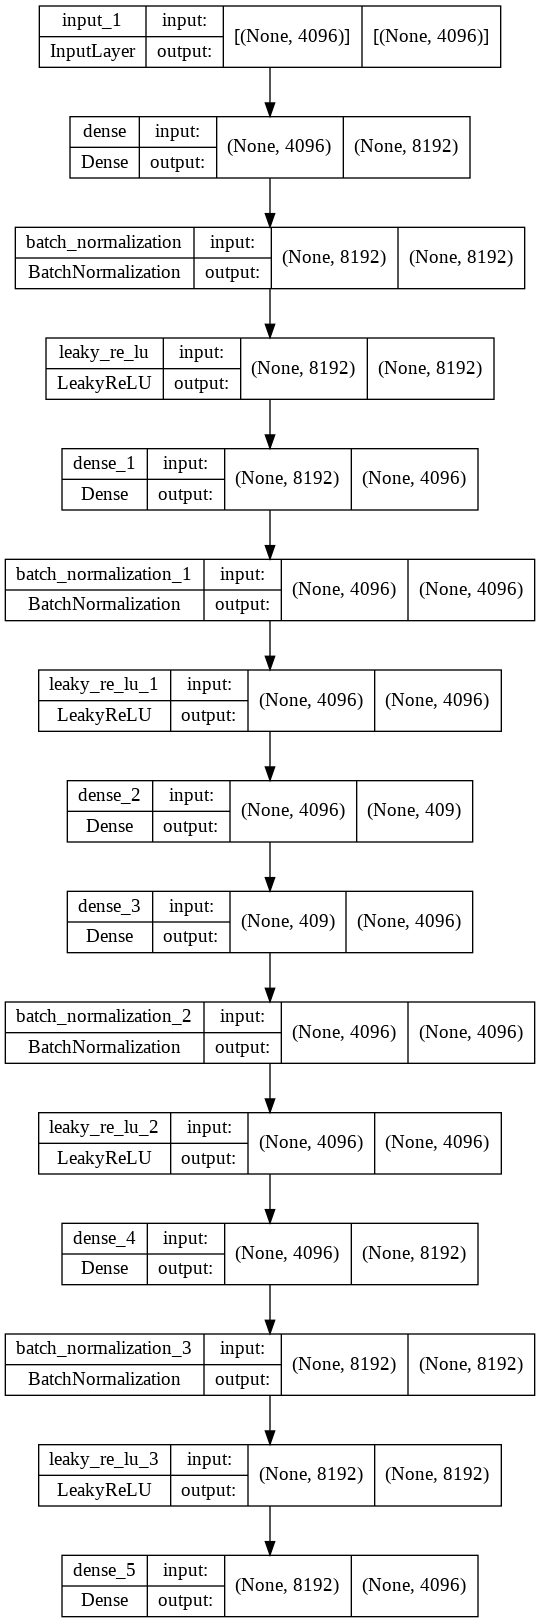

In [15]:
### make sure the auto encoder architecture
plot_model(model, show_shapes=True)

In [16]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [17]:

# play with number of epochs
history = model.fit(X_train, X_train, epochs=25, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/25
32/32 - 5s - loss: 0.3551 - val_loss: 25.7781 - 5s/epoch - 167ms/step
Epoch 2/25
32/32 - 1s - loss: 0.0667 - val_loss: 0.6764 - 1s/epoch - 33ms/step
Epoch 3/25
32/32 - 1s - loss: 0.0593 - val_loss: 0.1640 - 1s/epoch - 35ms/step
Epoch 4/25
32/32 - 1s - loss: 0.0548 - val_loss: 0.1318 - 1s/epoch - 33ms/step
Epoch 5/25
32/32 - 1s - loss: 0.0774 - val_loss: 0.1497 - 1s/epoch - 35ms/step
Epoch 6/25
32/32 - 1s - loss: 0.0671 - val_loss: 0.1134 - 1s/epoch - 33ms/step
Epoch 7/25
32/32 - 1s - loss: 0.0639 - val_loss: 0.1482 - 1s/epoch - 33ms/step
Epoch 8/25
32/32 - 1s - loss: 0.0692 - val_loss: 0.2110 - 1s/epoch - 33ms/step
Epoch 9/25
32/32 - 1s - loss: 0.0637 - val_loss: 0.1979 - 1s/epoch - 33ms/step
Epoch 10/25
32/32 - 1s - loss: 0.0629 - val_loss: 0.1664 - 1s/epoch - 35ms/step
Epoch 11/25
32/32 - 1s - loss: 0.0857 - val_loss: 0.1624 - 1s/epoch - 33ms/step
Epoch 12/25
32/32 - 1s - loss: 0.0811 - val_loss: 0.0971 - 1s/epoch - 33ms/step
Epoch 13/25
32/32 - 1s - loss: 0.0575 - val_los

### Visualize the model metrics for evaluation

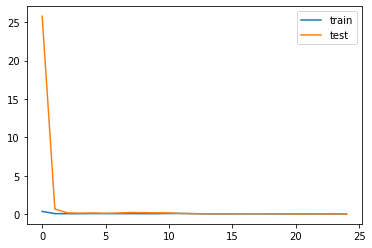

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

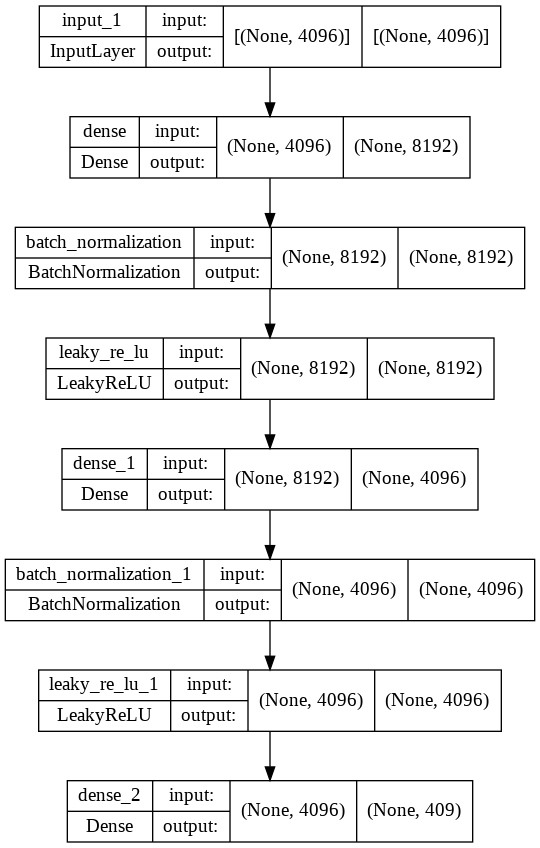

In [19]:
# define an encoder model (without the decoder) that will be used for predictive outcomes
encoder = Model(inputs=inp, outputs=bottleneck)
# check the final architecture
plot_model(encoder, 'encoder_compress.png', show_shapes=True)

**Now we will use our trained encoder to transform the data that will be further used to perfrom image classification**

In [20]:
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)

In [21]:
### data before encoding
print('data before encoding')
print(X_train[:5])
### data after encoding
print('data after encoding')
print(X_train_encode[:5])

data before encoding
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
data after encoding
[[ -0.47170216   2.0992794    0.75263023 ...  -3.007324    -3.0702782
   -1.7186993 ]
 [  1.2383217    1.0566585   -0.23608312 ...  -2.0997887   -1.1459014
   -3.0488856 ]
 [  2.5893843   -3.620427     8.537521   ...  -1.7157136   -4.9988685
   -4.1684203 ]
 [  1.4038906   -0.40481     -3.504097   ...   0.6358593   -5.393351
   -0.22221467]
 [  0.36142278 -15.85098      9.003806   ...  -1.1143745   13.354641
   16.786295  ]]


### Building a Neural network for classification

In [22]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               1048832   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,090,179
Trainable params: 1,090,179
Non-

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
16/16 [==============================] - 1s 15ms/step - loss: 0.3954 - accuracy: 0.8586 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 0.0457 - accuracy: 0.9841 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 3/20
16/16 [==============================] - 0s 6ms/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 8.4236e-05 - val_accuracy: 1.0000
Epoch 5/20
16/16 [==============================] - 0s 6ms/step - loss: 0.0071 - accuracy: 0.9960 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 6/20
16/16 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 8.3706e-05 - val_accuracy: 1.0000
Epoch 7/20
16/16 [==============================] - 0s 5ms/step - loss: 4.3005e-04 - accuracy: 1.0000 - val_loss: 1.5506e-04 - val_accuracy: 1.0000
Epo

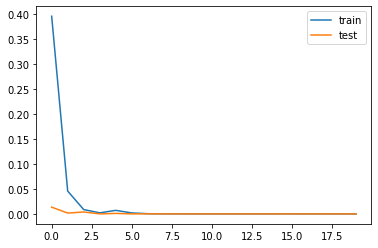

In [26]:
#### ploting the model curves to visualize the metrics
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [27]:
predictions_test = model.predict(X_test)

### making the prediction on an image from test data

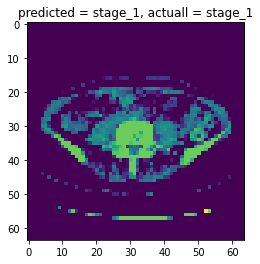

In [28]:
image_number = 10

pred_class_name = cats[np.argmax(predictions_test[image_number])]
actual_label = cats[np.argmax(y_test.values[image_number])]

plt.imshow(X_test[image_number].reshape(shape))
plt.title(f'predicted = {pred_class_name}, actuall = {actual_label}')
plt.show()

In [29]:

#### checking different combinations of bottleneck size
sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

experiments  = {'reduction_pct':[], 
                'train_loss': [], 
                'val_loss':[]}

for pct_size in sizes:
  inp = Input(shape=(num_input_features,))
  # encoder level 1
  e = Dense(num_input_features*2)(inp)
  e = BatchNormalization()(e)
  e = LeakyReLU()(e)

  # encoder level 2
  e = Dense(num_input_features)(e)
  e = BatchNormalization()(e)
  e = LeakyReLU()(e)


  # bottleneck
  features_reduce = (pct_size/100) * num_input_features
  features_to_use = int(num_input_features - features_reduce)
  n_bottleneck = features_to_use
  bottleneck = Dense(n_bottleneck)(e)

  # level 1
  d = Dense(num_input_features)(bottleneck)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)
  # decoder level 2
  d = Dense(num_input_features*2)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)

  # output layer
  output = Dense(num_input_features, activation='linear')(d)
  # define autoencoder model
  model = Model(inputs=inp, outputs=output)

  # compile autoencoder model
  model.compile(optimizer='adam', loss='mse')
  print(f'Training with reduction percentage of {pct_size} %.')
  # play with number of epochs
  history = model.fit(X_train, X_train, epochs=5, batch_size=16, verbose=False, validation_data=(X_test,X_test))

  final_loss_tr = history.history['loss'][-1]
  final_loss_val = history.history['val_loss'][-1]
  
  experiments['train_loss'].append(final_loss_tr)
  experiments['val_loss'].append(final_loss_val)

experiments['reduction_pct'] = sizes



Training with reduction percentage of 10 %.
Training with reduction percentage of 20 %.
Training with reduction percentage of 30 %.
Training with reduction percentage of 40 %.
Training with reduction percentage of 50 %.
Training with reduction percentage of 60 %.
Training with reduction percentage of 70 %.
Training with reduction percentage of 80 %.
Training with reduction percentage of 90 %.
Training with reduction percentage of 100 %.


In [30]:
experiments

{'reduction_pct': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'train_loss': [0.15125590562820435,
  0.06552434712648392,
  0.05878005921840668,
  0.06549437344074249,
  0.05730660632252693,
  0.06156650930643082,
  0.10450828075408936,
  0.07012856006622314,
  0.057595402002334595,
  0.03829718753695488],
 'val_loss': [0.4412466585636139,
  0.08826813101768494,
  0.07320241630077362,
  0.11725960671901703,
  0.18978896737098694,
  0.24814872443675995,
  0.20289230346679688,
  0.07941601425409317,
  0.07504136860370636,
  0.03855494037270546]}

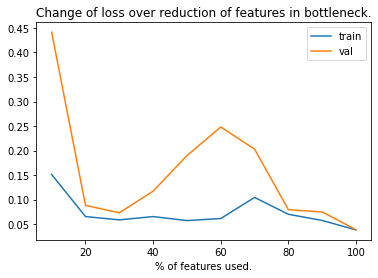

In [31]:
#### ploting the model curves to visualize the metrics
plt.title('Change of loss over reduction of features in bottleneck.')
plt.plot(experiments['reduction_pct'], experiments['train_loss'], label='train')
plt.plot(experiments['reduction_pct'], experiments['val_loss'], label='val')
plt.xlabel('% of features used.')
plt.legend()
plt.show()